In [1]:
import numpy as np
import pandas as pd
import warnings


from globalbonds.dataio.data_lib import DataLib
from globalbonds.indicators.data_utils import *
from globalbonds.indicators.signal import Signal
from globalbonds.indicators.indicator import Indicator
from globalbonds.indicators.assess_signal import predictive_accuracy
from globalbonds.indicators.return_utils import *
from globalbonds.indicators.normalization import *


from plotnine import *

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

warnings.filterwarnings('ignore')


COUNTRIES = ['USA', 'JPN', 'AUS', 'DEU']
#COUNTRIES = ['JPN', 'CAN', 'ESP', 'DEU', 'ITA', 'GBR', 'NOR', 'AUS', 'USA', 'SWE']
dlib = DataLib('../SignalData')
START_DATE = '1983-01-01'
END_DATE = '2010-01-01'
END_DATE = '2020-01-01'


def mask(tbl):
    tbl = tbl[COUNTRIES]
    tbl = tbl.loc['1980-01-01':END_DATE]
    return tbl


bond_returns = mask(dlib.pull('BondRetIdx-LocalFX')).resample('M').mean()
cash_rate = get_cash_rate(dlib).loc[START_DATE:END_DATE]

optimal_signal = (bond_returns.pct_change() + 1)

def minmaxsig(row):
    out = row.copy().fillna(0)
    out[:] = 0
    out[row.idxmax()] = 1
    out[row.idxmin()] = -1
    return out

optimal_signal = optimal_signal.apply(minmaxsig, axis=1)
optimal_signal = optimal_signal.drop(columns=[
    el for el in optimal_signal.columns if not isinstance(el, str)
])
optimal_signal = optimal_signal.loc[START_DATE:END_DATE]
bond_change = bond_returns.pct_change()
bond_returns = bond_returns.loc[START_DATE:END_DATE]
bond_change = bond_change.loc[START_DATE:END_DATE]

dlib.list()

/home/dcdanko/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


['GDP-Real',
 'EquityPrices',
 'LongRates',
 'CurrAcctNom-inUSD',
 'CoreCPI-SA',
 'fxTrdWts-Real',
 'M3-inUSD',
 'RiskFree-Rate',
 'CurrAcctPctGDP',
 'fxTrdWts-Nominal',
 'BondRetIdx-LocalFX',
 'fxVsUSD',
 'M2-inUSD',
 'M1-inUSD',
 'ShortRates',
 'GDP-Nominal']

In [2]:
bond_change

country,USA,JPN,AUS,DEU
date,,,,
1983-01,0.012996,NaN,NaN,0.009676
1983-02,-0.004674,NaN,NaN,-0.001468
1983-03,0.019884,NaN,NaN,0.026204
1983-04,0.015324,NaN,NaN,0.000123
1983-05,0.006867,NaN,NaN,-0.005600
...,...,...,...,...
2019-09,-0.004990,-0.000307,-0.005371,-0.005852
2019-10,0.001123,-0.004602,0.000605,-0.012442
2019-11,-0.009628,-0.007126,-0.010113,-0.012206


In [6]:
optimal_signal * bond_change

,AUS,DEU,JPN,USA
date,,,,
1983-01,NaN,-0.009676,NaN,0.012996
1983-02,NaN,-0.001468,NaN,0.004674
1983-03,NaN,0.026204,NaN,-0.019884
1983-04,NaN,-0.000123,NaN,0.015324
1983-05,NaN,0.005600,NaN,0.006867
...,...,...,...,...
2019-09,-0.000000,0.005852,-0.000307,-0.000000
2019-10,0.000000,0.012442,-0.000000,0.001123
2019-11,-0.000000,0.012206,-0.007126,-0.000000


In [7]:
(optimal_signal * bond_change).sum(axis=1)

date
1983-01    0.003320
1983-02    0.003205
1983-03    0.006319
1983-04    0.015200
1983-05    0.012467
             ...   
2019-09    0.005545
2019-10    0.013565
2019-11    0.005080
2019-12    0.004648
2020-01    0.014554
Freq: M, Length: 445, dtype: float64

In [5]:
cash_rate

date
1983-01    0.006512
1983-02    0.006341
1983-03    0.006907
1983-04    0.006488
1983-05    0.006868
             ...   
2019-09    0.001521
2019-10    0.001250
2019-11    0.001291
2019-12    0.001258
2020-01    0.001258
Freq: M, Name: USA, Length: 445, dtype: float64

In [8]:
(optimal_signal * bond_change).sum(axis=1) - cash_rate

date
1983-01   -0.003192
1983-02   -0.003136
1983-03   -0.000587
1983-04    0.008712
1983-05    0.005599
             ...   
2019-09    0.004024
2019-10    0.012315
2019-11    0.003789
2019-12    0.003390
2020-01    0.013296
Freq: M, Length: 445, dtype: float64

In [10]:
ret_less_cash = ((optimal_signal * bond_change).sum(axis=1) - cash_rate)
(ret_less_cash + 1).cumprod()

date
1983-01       0.996808
1983-02       0.993682
1983-03       0.993099
1983-04       1.001751
1983-05       1.007359
              ...     
2019-09    1790.772594
2019-10    1812.826498
2019-11    1819.696182
2019-12    1825.864892
2020-01    1850.142412
Freq: M, Length: 445, dtype: float64

In [61]:

fs = 10
f = 100
t = 20

sample_rate = 60

time = np.arange(0, 6, 1 / sample_rate);
signal = np.sin(np.pi * time)

len(signal)

360

330
330


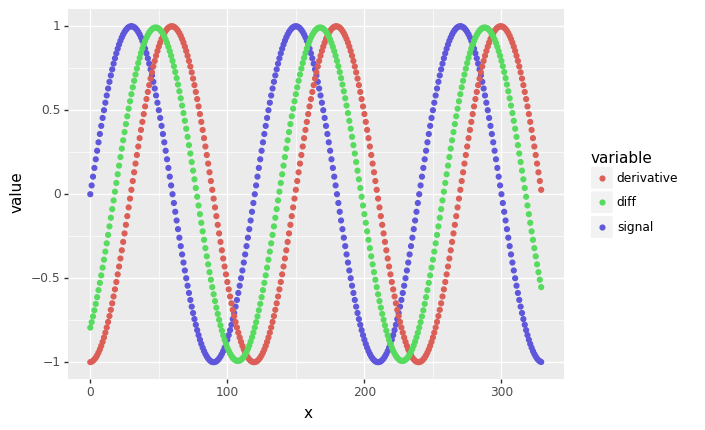

<ggplot: (-9223363243221798712)>

In [84]:

p1, p2 = 12, 30
year1_diff = signal[:-p1] - signal[p1:]
year1_diff = year1_diff[:-(p2 - p1)]
print(len(year1_diff))
year3_diff = signal[:-p2] - signal[p2:]
print(len(year3_diff))

mean_diff = (year1_diff + year3_diff) / 2
actual_deriv = (signal[:-1] - signal[1:]) * sample_rate / np.pi

t = pd.DataFrame.from_dict({
    'x': list(range(len(mean_diff))),
    'signal': signal[:len(mean_diff)],
    'derivative': actual_deriv[:len(mean_diff)],
    #'y1': year1_diff[:len(mean_diff)],
    'diff': mean_diff,
}, orient='columns')
t = t.melt(id_vars='x')
(
    ggplot(t, aes(x='x', y='value', color='variable')) +
        geom_point()
)